In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
pd.options.display.max_columns=999
df = pd.read_csv('Untitled spreadsheet - Sheet1.csv')
df = df.drop('Unnamed: 3', 1)
df = df.dropna()
borders = []
for i in df['Borders']:
    borders.append(i.split('/'))
within = []
for i in df['Within']:
    within.append(i.split('/'))
df['Borders'] = borders
df['Within'] = within
df2 = df.drop(0)
borders = []
for n in df.index:
    x = df.loc[n][0]
    for i in df.loc[n][-1]:
        borders.append([x,i])
borders = pd.DataFrame(borders)
borders = borders.drop([0,1]).reset_index().drop('index',1)
# quality of life indicators
cpi = pd.read_csv('cpi.csv')
cpi = cpi[['Country','2015 cpi']]
cpi = cpi.replace('-',np.nan)
cpi['2015 cpi'] = [float(x) for x in cpi['2015 cpi']]
edbi = pd.read_csv('edbiscores.csv')
homicide = pd.read_csv('homicide.csv')
pfi = pd.read_csv('pfi.csv')[['Country','Score']]
pfi.columns = ['Country','2018 pfi']
pfi['2018 pfi'] = [float(x) for x in pfi['2018 pfi']]
homicide.columns = ['Country','Region','Subregion','Homicide Rate','Homicide County','Year','Source']
qol = pd.merge(cpi,pfi,on='Country')
qol = pd.merge(qol,edbi,on='Country')
qol = pd.merge(qol, homicide, on='Country')
qol['score'] = qol['2015 cpi'] / qol['2018 pfi'] * qol['DB 2019']
qol.head()
#GDP and Population
data = pd.read_csv('world_indicators_all_years.csv')
data = data[data['Time'] == '2016']
data = data.replace('Iran, Islamic Rep.','Iran').replace('Korea, Dem. People’s Rep.',"Democratic People's Republic of Korea").replace('Lao PDR','Laos').replace('Korea, Rep.','Korea,South').replace('Macedonia, FYR','Macedonia').replace('Myanmar','Myanmar (Burma)').replace('Russian Federation','Russia').replace('Slovak Republic','Slovakia').replace('Syrian Arab Republic','Syria').replace('Venezuela, RB','Venezuela').replace('Yemen, Rep.','Yemen')
data1 = data[['Country Name', 'Population, total [SP.POP.TOTL]','Population growth (annual %) [SP.POP.GROW]','GDP (current US$) [NY.GDP.MKTP.CD]', 'GDP per capita (current US$) [NY.GDP.PCAP.CD]']]
data1 = data1.replace('..',np.nan)
for x in [*data1.columns][1:]:
    data1[x] = [float(i) for i in data1[x]]
data1['Population, total [SP.POP.TOTL]'] = [float(n) for n in data1['Population, total [SP.POP.TOTL]']]
data1 = pd.merge(qol,data1,left_on='Country',right_on='Country Name')
#treaties
schengen = ['Austria','Belgium','Czech Republic','Denmark','Estonia','Finland','France','Germany','Greece','Hungary','Iceland','Italy','Latvia','Liechtenstein','Lithuania','Luxembourg','Malta','Netherlands','Monaco','Norway','Poland','Portugal','San Marino','Slovakia','Slovenia','Spain','Sweden','Switzerland','Vatican City']
common = ['Ireland','United Kingdom']
unionstate = ['Russia','Belarus']
peaceandfriendship = ['India','Bhutan','Nepal']
ca4 = ['El Salvador','Honduras','Guatemala','Nicaragua']
tasman = ['Australia','New Zealand']
andean = ['Bolivia','Ecuador','Colombia','Peru']
caricom = ['Antigua and Barbuda','Barbados', 'Belize', 'Dominica', 'Grenada','Guyana','Jamaica','Saint Kitts and Nevis','Saint Lucia','Saint Vincent and the Grenadines','Suriname','Trinidad and Tobago']
gcc = ['Saudi Arabia','Oman','Kuwait','United Arab Emirates','Bahrain']
eac = ['Kenya','Tanzania','Uganda','South Sudan','Rwanda','Burundi']
table = [schengen+common+unionstate+peaceandfriendship+ca4+tasman+andean+caricom+gcc+eac,['Schengen'] * len(schengen) + ['Common'] * len(common) + ['Union State'] * len(unionstate) + ['Peace and Friendship'] * len(peaceandfriendship) + ['Central America 4'] * len(ca4) + ['Trans-Tasman Agreement'] * len(tasman) + ['Andean Community'] * len(andean) + len(caricom) * ['Caricom'] + len(gcc) * ['Gulf Cooperation Council'] + ['East African Community'] * len(eac)]
treaties = pd.DataFrame(table).transpose()
treaties.columns = ['Country','Treaty']
notreaty = pd.DataFrame([*set(treaties['Country'])^set(data1['Country Name'])])
notreaty['Treaty'] = None
notreaty.columns = ['Country','Treaty']
treaties = pd.concat([notreaty,treaties])
data1 = pd.merge(data1,treaties)
#bring it all together
test1 = pd.merge(borders,data1,left_on=0,right_on='Country Name')
test1.columns = ['Country 1','Country 2','C','2015 cpi', '2018 pfi', 'DB 2018',
       'DB 2019', 'Region', 'Subregion', 'Homicide Rate', 'Homicide County',
       'Year', 'Source', 'score', 'Country Name','Population 1','Population growth 1','GDP 1','GDP per capita 1','Treaty 1']
test1['Country 2'] = [s.rstrip(" ").lstrip(' ') for s in test1['Country 2']]
test2 = pd.merge(test1,data1,left_on='Country 2',right_on='Country Name')
#More statistics
test2.columns = ['Country 1', 'Country 2', 'C', '2015 cpi_x', '2018 pfi_x', 'DB 2018_x', 'DB 2019_x', 'Region_x', 'Subregion_x',
       'Homicide Rate_x', 'Homicide County_x', 'Year_x', 'Source_x', 'score_x',
       'Country Name_x', 'Population 1', 'Population growth 1', 'GDP 1',
       'GDP per capita 1','Treaty 1', 'Country', '2015 cpi_y', '2018 pfi_y', 'DB 2018_y', 'DB 2019_y', 'Region_y', 'Subregion_y',
       'Homicide Rate_y', 'Homicide County_y', 'Year_y', 'Source_y', 'score_y',
       'Country Name_y', 'Population 2',
       'Population growth 2','GDP 2','GDP per capita 2','Treaty 2']
test2['Population difference'] = test2['Population 1'] / test2['Population 2']
test2['Population growth difference'] = test2['Population growth 1']/ test2['Population growth 2']
test2['GDP difference'] = test2['GDP 1'] / test2['GDP 2']
test2['GDP per capita difference'] = test2['GDP per capita 1'] / test2['GDP per capita 2']
df1 = test2
test2['Population difference'] = [1/x if x > 1 else x for x in test2['Population difference'] ]
test2['Population growth difference'] = [1/x if x > 1 else x for x in test2['Population growth difference']]
test2['GDP difference'] = [1/x if x > 1 else x for x in test2['GDP difference']]
test2['GDP per capita difference'] = [1/x if x > 1 else x for x in test2['GDP per capita difference']]
test2 = pd.merge(test2,df2, left_on='Country 1', right_on='Name of country').drop('Borders',1)
test2['GDP product'] = test2['GDP 1'] *test2['GDP 2']
test2['GDP per capita in both'] = (test2['GDP 1'] + test2['GDP 2']) / (test2['Population 1'] + test2['Population 2'])
test2 = test2.drop_duplicates('GDP product').reset_index()
df1['cpi difference'] = df1['2015 cpi_x'] / df1['2015 cpi_y']
#df1['cpi difference'] = [1/x if x > 1 for x in df1['cpi difference'] else x]
df1['cpi difference'] = [1/x if x > 1 else x for x in df1['cpi difference']]
df1['db difference'] = df1['DB 2019_x'] / df1['DB 2019_y']
df1['db difference'] = [1/x if x > 1 else x for x in df1['db difference']]
df1['pfi difference'] = df1['2018 pfi_x'] / df1['2018 pfi_y']
df1['pfi difference'] = [1/x if x > 1 else x for x in df1['pfi difference']]
df1['homicide difference'] = df1['Homicide Rate_x'] / df1['Homicide Rate_y']
df1['homicide difference'] = [1/x if x > 1 else x for x in df1['homicide difference']]
df1['Country Similarity'] = (df1['cpi difference']+df1['db difference']+df1['pfi difference']+df1['homicide difference']) /4
df1['average cpi'] = df1[['2015 cpi_x','2015 cpi_y']].mean(axis=1)
df1['average db'] = df1[['DB 2019_x','DB 2019_y']].mean(axis=1)
df1['average pfi'] = df1[['2018 pfi_x','2018 pfi_y']].mean(axis=1)
df1['average score']=df1['score_x']+df1['score_y']
df1['average homicide'] = df1[['Homicide Rate_x','Homicide Rate_y']].mean(axis=1)
df1['Border Status'] = np.where(df1['Treaty 1'] == df1['Treaty 2'], 'Open', 'Closed')
df1['Combined Population'] = df1['Population 1'] + df1['Population 2']
df1['viability'] = df1['average cpi'] * df1['average db'] / (df1['average pfi'] * df1['average homicide'])
df1['viability2'] = df1['average cpi'] * df1['average db'] * df1['GDP per capita difference'] / (df1['average pfi'] * df1['average homicide'])
df1 = df1.drop_duplicates('Combined Population').sort_values('viability', ascending = False).reset_index().drop('index',1)
df1.head()

Country 1    Country 2            C  2015 cpi_x  2018 pfi_x  DB 2018_x  \
0       Sweden       Norway       Sweden        89.0        8.31      81.27   
1      Finland       Norway      Finland        90.0       10.26      80.30   
2      Austria  Switzerland      Austria        76.0       14.04      78.54   
3      Finland       Sweden      Finland        90.0       10.26      80.30   
4  Netherlands      Germany  Netherlands        87.0       10.01      76.03   

   DB 2019_x Region_x      Subregion_x  Homicide Rate_x  Homicide County_x  \
0      81.27   Europe  Northern Europe             1.08              106.0   
1      80.35   Europe  Northern Europe             1.42               78.0   
2      78.57   Europe   Western Europe             0.66               57.0   
3      80.35   Europe  Northern Europe             1.42               78.0   
4      76.04   Europe   Western Europe             0.55               94.0   

   Year_x       Source_x     score_x Country Name_x  Population 1  \
0  2016.0       NCCP/CTS  870.400722         Sweden     9903122.0   
1  2016.0      UNSDC/CTS  704.824561        Finland     5495096.0   
2  2016.0  EUR/UNSDC/CTS  425.307692        Austria     8747358.0   
3  2016.0      UNSDC/CTS  704.824561        Finland     5495096.0   
4  2016.0        NSO/CTS  660.887113    Netherlands    17018408.0   

   Population growth 1         GDP 1  GDP per capita 1  Treaty 1      Country  \
0             1.055074  5.144600e+11      51949.271432  Schengen       Norway   
1             0.283654  2.385029e+11      43402.863264  Schengen       Norway   
2             1.314007  3.908000e+11      44676.345835  Schengen  Switzerland   
3             0.283654  2.385029e+11      43402.863264  Schengen       Sweden   
4             0.462244  7.772275e+11      45669.814802  Schengen      Germany   

   2015 cpi_y  2018 pfi_y  DB 2018_y  DB 2019_y Region_y      Subregion_y  \
0        87.0        7.63      82.70      82.95   Europe  Northern Europe   
1        87.0        7.63      82.70      82.95   Europe  Northern Europe   
2        86.0       11.27      75.68      75.69   Europe   Western Europe   
3        89.0        8.31      81.27      81.27   Europe  Northern Europe   
4        81.0       14.39      78.90      78.90   Europe   Western Europe   

   Homicide Rate_y  Homicide County_y  Year_y       Source_y     score_y  \
0             0.51               27.0  2016.0    SDG/EUR/CTS  945.825688   
1             0.51               27.0  2016.0    SDG/EUR/CTS  945.825688   
2             0.54               45.0  2016.0  UNSDC/EUR/CTS  577.581189   
3             1.08              106.0  2016.0       NCCP/CTS  870.400722   
4             1.18              963.0  2016.0      UNSDC/CTS  444.120917   

  Country Name_y  Population 2  Population growth 2         GDP 2  \
0         Norway     5232929.0             0.850590  3.710762e+11   
1         Norway     5232929.0             0.850590  3.710762e+11   
2    Switzerland     8372098.0             1.077221  6.688513e+11   
3         Sweden     9903122.0             1.055074  5.144600e+11   
4        Germany    82667685.0             1.193867  3.477796e+12   

   GDP per capita 2  Treaty 2  Population difference  \
0      70911.757159  Schengen               0.528412   
1      70911.757159  Schengen               0.952291   
2      79890.524005  Schengen               0.957100   
3      51949.271432  Schengen               0.554885   
4      42069.597987  Schengen               0.205865   

   Population growth difference  GDP difference  GDP per capita difference  \
0                      0.806190        0.721293                   0.732590   
1                      0.333480        0.642733                   0.612069   
2                      0.819799        0.584285                   0.559220   
3                      0.268848        0.463599                   0.835486   
4                      0.387182        0.223483                   0.921169   

   cpi difference 

In [3]:
df1.shape

(208, 56)

In [4]:
len(set(set(df1['Country 1'])|set(df1['Country 2'])))

124

In [5]:
df1[df1['2015 cpi_x'] > 70][df1['2015 cpi_y'] > 70][df1['Border Status'] == 'Closed']

/home/matthew/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Country 1      Country 2       C  2015 cpi_x  2018 pfi_x  DB 2018_x  \
34    Canada  United States  Canada        83.0       15.28      78.88   

    DB 2019_x  Region_x       Subregion_x  Homicide Rate_x  Homicide County_x  \
34      79.26  Americas  Northern America             1.68              611.0   

    Year_x     Source_x    score_x Country Name_x  Population 1  \
34  2016.0  OAS/CTS/SDG  430.53534         Canada    36286425.0   

    Population growth 1         GDP 1  GDP per capita 1 Treaty 1  \
34             1.213891  1.529760e+12      42157.927991     None   

          Country  2015 cpi_y  2018 pfi_y  DB 2018_y  DB 2019_y  Region_y  \
34  United States        76.0       23.73      82.76      82.75  Americas   

         Subregion_y  Homicide Rate_y  Homicide County_y  Year_y  \
34  Northern America             5.35            17250.0  2016.0   

        Source_y     score_y Country Name_y  Population 2  \
34  NP/UNSDC/CTS  265.023177  United States   323127513.0   

    Population growth 2         GDP 2  GDP per capita 2 Treaty 2  \
34             0.692801  1.862448e+13      57638.159088     None   

    Population difference  Population growth difference  GDP difference  \
34               0.112298                      0.570728        0.082137   

    GDP per capita difference  cpi difference  db difference  pfi difference  \
34                   0.731424        0.915663       0.957825        0.643911   

    homicide difference  Country Similarity  average cpi  average db  \
34             0.314019            0.707854         79.5      81.005   

    average pfi  average score  average homicide Border Status  \
34       19.505     695.558518             3.515        Closed   

    Combined Population  viability  viability2  
34          359413938.0  93.930724   68.703178

In [6]:
df1[['Country 1', 'Country 2', 'Border Status', 'Combined Population','average score',
       'viability','GDP per capita difference']].sort_values('GDP per capita difference')

Country 1                 Country 2 Border Status  Combined Population  \
144  Afghanistan                     China        Closed         1.413321e+09   
166   Mozambique              South Africa        Closed         8.473834e+07   
72         Nepal                     China        Closed         1.407648e+09   
91       Algeria                     Niger        Closed         6.127904e+07   
70    Tajikistan                     China        Closed         1.387400e+09   
..           ...                       ...           ...                  ...   
195     Ethiopia               South Sudan        Closed         1.146339e+08   
197       Uganda               South Sudan          Open         5.371870e+07   
203      Eritrea                     Sudan        Closed                  NaN   
205  South Sudan  Central African Republic        Closed         1.682535e+07   
206        Sudan               South Sudan        Closed         5.180956e+07   

     average score  viability  GDP per capita difference  
144      48.897627   7.234655                   0.069157  
166     197.803368   4.736279                   0.072299  
72       85.036723  27.805749                   0.089758  
91      108.102006  17.688487                   0.092973  
70       64.464007  28.779385                   0.097972  
..             ...        ...                        ...  
195      43.577476   1.945174                        NaN  
197      50.102807   1.738163                        NaN  
203      13.169049   1.051888                        NaN  
205      36.430998   1.019123                        NaN  
206      19.547155   1.010488                        NaN  

[208 rows x 7 columns]

In [7]:
df1[['Country 1', 'Country 2','score_x','score_y', 'Border Status', 'Combined Population','average score',
       'viability']][df1['Border Status']=='Closed'].sort_values('average score', ascending=False)

Country 1          Country 2     score_x     score_y Border Status  \
34       Canada      United States  430.535340  265.023177        Closed   
132     Uruguay             Brazil  297.712082   73.089103        Closed   
81    Argentina            Uruguay   72.230326  297.712082        Closed   
105  Costa Rica             Panama  270.446110   84.380890        Closed   
26      Croatia           Slovenia  125.825847  209.156293        Closed   
..          ...                ...         ...         ...           ...   
203     Eritrea              Sudan    4.929487    8.239561        Closed   
145    Cameroon  Equatorial Guinea   31.526393         NaN        Closed   
157       Gabon  Equatorial Guinea   47.875193         NaN        Closed   
192      Belize             Mexico         NaN   51.587610        Closed   
198      Belize          Guatemala         NaN   48.127177        Closed   

     Combined Population  average score   viability  
34           359413938.0     695.558518   93.930724  
132          211096871.0     370.801185    7.890291  
81            47291436.0     369.942409   22.689816  
105            8891393.0     354.827000   13.200823  
26             6235445.0     334.982140  212.040266  
..                   ...            ...         ...  
203                  NaN      13.169049    1.051888  
145           24660679.0            NaN    6.962163  
157            3201276.0            NaN    5.817590  
192          127907377.0            NaN    2.165559  
198           16949423.0            NaN    1.696367  

[152 rows x 8 columns]

In [8]:
df1[['Country 1', 'Country 2','score_x','score_y', 'Border Status', 'Combined Population','average score',
       'viability']][df1['Border Status']=='Closed'].sort_values('viability', ascending=False)

Country 1                 Country 2     score_x     score_y  \
26       Croatia                  Slovenia  125.825847  209.156293   
32         Ghana              Burkina Faso  151.186312   83.997428   
33      Bulgaria                    Greece   82.931289  107.286057   
34        Canada             United States  430.535340  265.023177   
35     Singapore                  Malaysia  142.206084   85.003164   
..           ...                       ...         ...         ...   
199         Chad  Central African Republic   22.520676   25.123404   
202        Sudan  Central African Republic    8.239561   25.123404   
203      Eritrea                     Sudan    4.929487    8.239561   
205  South Sudan  Central African Republic   11.307594   25.123404   
206        Sudan               South Sudan    8.239561   11.307594   

    Border Status  Combined Population  average score   viability  
26         Closed            6235445.0     334.982140  212.040266  
32         Closed           46853161.0     235.183740  110.055863  
33         Closed           17874562.0     190.217346   99.567503  
34         Closed          359413938.0     695.558518   93.930724  
35         Closed           36794548.0     227.209248   93.669513  
..            ...                  ...            ...         ...  
199        Closed           19047164.0      47.644080    1.652702  
202        Closed           44173449.0      33.362966    1.164335  
203        Closed                  NaN      13.169049    1.051888  
205        Closed           16825351.0      36.430998    1.019123  
206        Closed           51809558.0      19.547155    1.010488  

[152 rows x 8 columns]

In [9]:
df1[['Country 1', 'Country 2', '2015 cpi_x', '2018 pfi_x', 'DB 2018_x',
       'DB 2019_x', '2015 cpi_y', '2018 pfi_y', 'DB 2018_y',
       'DB 2019_y', 'Country Similarity', 'average cpi', 'average db', 'average pfi',
       'average score', 'average homicide', 'Border Status',
       'Combined Population', 'viability']][df1['Border Status']=='Closed'].sort_values('Country Similarity',ascending=False)

Country 1          Country 2  2015 cpi_x  2018 pfi_x  DB 2018_x  \
45       Bulgaria             Serbia        41.0       35.22      71.13   
162    Mauritania               Mali        31.0       29.09      51.07   
60   Saudi Arabia             Jordan        52.0       63.13      61.88   
38        Romania             Serbia        46.0       23.65      72.83   
119     Argentina            Bolivia        32.0       26.05      57.93   
..            ...                ...         ...         ...        ...   
144   Afghanistan              China        11.0       37.28      37.13   
145      Cameroon  Equatorial Guinea        27.0       40.92      46.95   
157         Gabon  Equatorial Guinea        34.0       32.37      45.81   
192        Belize             Mexico         NaN       24.55      57.11   
198        Belize          Guatemala         NaN       24.55      57.11   

     DB 2019_x  2015 cpi_y  2018 pfi_y  DB 2018_y  DB 2019_y  \
45       71.24        40.0       29.58      73.32      73.49   
162      51.99        35.0       36.15      53.27      53.50   
60       63.50        53.0       41.71      59.56      60.98   
38       72.30        40.0       29.58      73.32      73.49   
119      58.80        34.0       32.45      50.17      50.32   
..         ...         ...         ...        ...        ...   
144      47.77        37.0       78.29      65.00      73.64   
145      47.78         NaN       66.47      41.66      41.94   
157      45.58         NaN       66.47      41.66      41.94   
192      57.13        35.0       48.91      72.27      72.09   
198      57.13        28.0       36.17      61.16      62.17   

     Country Similarity  average cpi  average db  average pfi  average score  \
45             0.901250         40.5      72.365       32.400     182.309247   
162            0.893530         33.0      52.745       32.620     107.201639   
60             0.892472         52.5      62.240       52.420     129.790743   
38             0.888045         43.0      72.895       26.615     240.003751   
119            0.885647         33.0      54.560       29.250     124.953901   
..                  ...          ...         ...          ...            ...   
144            0.379952         24.0      60.705       57.785      48.897627   
145                 NaN         27.0      44.860       53.695            NaN   
157                 NaN         34.0      43.760       49.420            NaN   
192                 NaN         35.0      64.610       36.730            NaN   
198                 NaN         28.0      59.650       30.360            NaN   

     average homicide Border Status  Combined Population  viability  
45              1.265        Closed         1.418523e+07  71.506917  
162            10.420        Closed         2.229586e+07   5.120868  
60              1.525        Closed         4.173149e+07  40.875401  
38              1.320        Closed         2.676271e+07  89.220734  
119             6.120        Closed         5.473531e+07  10.057986  
..                ...           ...                  ...        ...  
144             3.485        Closed         1.413321e+09   7.234655  
145             3.240        Closed         2.466068e+07   6.962163  
157             5.175        Closed         3.201276e+06   5.817590  
192            28.430        Closed         1.279074e+08   2.165559  
198            32.430        Closed         1.694942e+07   1.696367  

[152 rows x 19 columns]

In [10]:
pd.options.display.max_rows=500

In [11]:
df1[['Country 1','Country 2','Border Status','viability']].sort_values('viability', ascending=False)

Country 1                 Country 2 Border Status    viability
0                  Sweden                    Norway          Open  1140.389669
1                 Finland                    Norway          Open   837.127871
2                 Austria               Switzerland          Open   822.801264
3                 Finland                    Sweden          Open   623.155197
4             Netherlands                   Germany          Open   616.647399
5             Switzerland                   Germany          Open   584.941951
6                 Austria                  Slovenia          Open   514.788791
7                 Austria                   Germany          Open   472.609881
8                 Denmark                   Germany          Open   458.866442
9             Switzerland                     Italy          Open   450.061767
10                Austria            Czech Republic          Open   447.423796
11             Luxembourg                   Germany          Open   433.228227
12                Belgium               Netherlands          Open   424.658783
13               Portugal                     Spain          Open   423.712639
14                 France               Switzerland          Open   381.017521
15                Austria                     Italy          Open   357.332009
16                Ireland            United Kingdom          Open   333.025370
17                Germany            Czech Republic          Open   326.988106
18                Belgium                Luxembourg          Open   303.436343
19                 Poland                   Germany          Open   293.967393
20               Slovenia                     Italy          Open   292.506478
21             Luxembourg                    France          Open   291.667822
22                 Poland            Czech Republic          Open   291.033351
23                Belgium                   Germany          Open   280.063550
24                 France                   Germany          Open   257.088027
25                  Spain                    France          Open   236.391284
26                Croatia                  Slovenia        Closed   212.040266
27                Belgium                    France          Open   192.322425
28                 France                     Italy          Open   183.885218
29                Austria                   Hungary          Open   162.631845
30                   Oman      United Arab Emirates          Open   135.109973
31               Slovenia                   Hungary          Open   126.723715
32                  Ghana              Burkina Faso        Closed   110.055863
33               Bulgaria                    Greece        Closed    99.567503
34                 Canada             United States        Closed    93.930724
35              Singapore                  Malaysia        Closed    93.669513
36                Croatia                    Serbia        Closed    92.719101
37                Estonia                    Latvia          Open    90.630456
38                Romania                    Serbia        Closed    89.220734
39               Bulgaria                   Romania        Closed    88.756518
40                  Qatar              Saudi Arabia        Closed    81.957688
41                Croatia                   Hungary        Closed    81.177165
42                Romania                   Hungary        Closed    80.063963
43                 Bhutan                     China        Closed    74.698954
44                 Israel                    Jordan        Closed    73.054208
45               Bulgaria                    Serbia        Closed    71.506917
46   United Arab Emirates              Saudi Arabia          Open    71.068790
47                 Poland                 Lithuania          Open    67.189984
48                Hungary                    Serbia        Closed    65.323484
49                Armenia                   Georgia        Closed 

In [12]:
df1[['Country 1','Country 2','Border Status','Country Similarity']].sort_values('Country Similarity', ascending=False).reset_index()

index             Country 1                 Country 2 Border Status  \
0       22                Poland            Czech Republic          Open   
1        8               Denmark                   Germany          Open   
2       45              Bulgaria                    Serbia        Closed   
3       13              Portugal                     Spain          Open   
4      162            Mauritania                      Mali        Closed   
5       60          Saudi Arabia                    Jordan        Closed   
6       38               Romania                    Serbia        Closed   
7        3               Finland                    Sweden          Open   
8      119             Argentina                   Bolivia        Closed   
9      108                 Benin                     Niger        Closed   
10      41               Croatia                   Hungary        Closed   
11     115               Ecuador                      Peru          Open   
12      36               Croatia                    Serbia        Closed   
13     181                  Chad                   Nigeria        Closed   
14     131                 Benin                      Togo        Closed   
15       7               Austria                   Germany          Open   
16       2               Austria               Switzerland          Open   
17     188              Colombia                    Brazil        Closed   
18      11            Luxembourg                   Germany          Open   
19      39              Bulgaria                   Romania        Closed   
20     183               Lesotho              South Africa        Closed   
21     121              Botswana                   Namibia        Closed   
22      37               Estonia                    Latvia          Open   
23     123                  Peru                   Bolivia          Open   
24      48               Hungary                    Serbia        Closed   
25      53             Lithuania                    Latvia          Open   
26     116            Mozambique                  Tanzania        Closed   
27      23               Belgium                   Germany          Open   
28      24                France                   Germany          Open   
29     167                Guinea                      Mali        Closed   
30      56               Albania                    Serbia        Closed   
31       0                Sweden                    Norway          Open   
32     107                 India                  Pakistan        Closed   
33      33              Bulgaria                    Greece        Closed   
34     170              Djibouti                  Ethiopia        Closed   
35      75               Albania                Montenegro        Closed   
36      79                Malawi                Mozambique        Closed   
37      71              Malaysia                  Thailand        Closed   
38      42               Romania                   Hungary        Closed   
39     150              Paraguay                   Bolivia        Closed   
40      20              Slovenia                     Italy          Open   
41      44                Israel                    Jordan        Closed   
42     124                 Kenya                  Tanzania          Open   
43     128               Senegal                Mauritania        Closed   
44     134             Argentina                  Paraguay        Closed   
45      10               Austria            Czech Republic          Open   
46      61          Saudi Arabia                    Kuwait          Open   
47     155          South Africa                   Namibia        Closed   
48     120              Tanzania                    Zambia        Closed   
49     199                  Chad  Central African Republic        Closed   
50      25                 Spain                    France          Open   
51      98               Moldova                   Uk

In [13]:
df1

Country 1                 Country 2                     C  \
0                  Sweden                    Norway                Sweden   
1                 Finland                    Norway               Finland   
2                 Austria               Switzerland               Austria   
3                 Finland                    Sweden               Finland   
4             Netherlands                   Germany           Netherlands   
5             Switzerland                   Germany           Switzerland   
6                 Austria                  Slovenia               Austria   
7                 Austria                   Germany               Austria   
8                 Denmark                   Germany               Denmark   
9             Switzerland                     Italy           Switzerland   
10                Austria            Czech Republic               Austria   
11             Luxembourg                   Germany            Luxembourg   
12                Belgium               Netherlands               Belgium   
13               Portugal                     Spain              Portugal   
14                 France               Switzerland                France   
15                Austria                     Italy               Austria   
16                Ireland            United Kingdom               Ireland   
17                Germany            Czech Republic               Germany   
18                Belgium                Luxembourg               Belgium   
19                 Poland                   Germany                Poland   
20               Slovenia                     Italy              Slovenia   
21             Luxembourg                    France            Luxembourg   
22                 Poland            Czech Republic                Poland   
23                Belgium                   Germany               Belgium   
24                 France                   Germany                France   
25                  Spain                    France                 Spain   
26                Croatia                  Slovenia               Croatia   
27                Belgium                    France               Belgium   
28                 France                     Italy                France   
29                Austria                   Hungary               Austria   
30                   Oman      United Arab Emirates                  Oman   
31               Slovenia                   Hungary              Slovenia   
32                  Ghana              Burkina Faso                 Ghana   
33               Bulgaria                    Greece              Bulgaria   
34                 Canada             United States                Canada   
35              Singapore                  Malaysia             Singapore   
36                Croatia                    Serbia               Croatia   
37                Estonia                    Latvia               Estonia   
38                Romania                    Serbia               Romania   
39               Bulgaria                   Romania              Bulgaria   
40                  Qatar              Saudi Arabia                 Qatar   
41                Croatia                   Hungary               Croatia   
42                Romania                   Hungary               Romania   
43                 Bhutan                     China                Bhutan   
44                 Israel                    Jordan                Israel   
45               Bulgaria                    Serbia              Bulgaria   
46   United Arab Emirates              Saudi Arabia  United Arab Emirates   
47                 Poland                 Lithuania                Poland   
48                Hungary                    Serbia               Hungary   
49                Armenia                   Georgia               Armenia   
50                   Oman              Saudi Arabia                  Oman   
51          

In [14]:
df1[['average cpi','average db','average pfi','GDP per capita difference','average score','Country Similarity','viability','viability2']].corr()

average cpi  average db  average pfi  \
average cpi                   1.000000    0.749939    -0.663882   
average db                    0.749939    1.000000    -0.422830   
average pfi                  -0.663882   -0.422830     1.000000   
GDP per capita difference     0.192282    0.150024    -0.307749   
average score                 0.880803    0.595661    -0.679980   
Country Similarity            0.294485    0.258426    -0.408194   
viability                     0.779286    0.516613    -0.553129   
viability2                    0.753501    0.497990    -0.554673   

                           GDP per capita difference  average score  \
average cpi                                 0.192282       0.880803   
average db                                  0.150024       0.595661   
average pfi                                -0.307749      -0.679980   
GDP per capita difference                   1.000000       0.221657   
average score                               0.221657       1.000000   
Country Similarity                          0.345546       0.275929   
viability                                   0.159474       0.923013   
viability2                                  0.270889       0.917316   

                           Country Similarity  viability  viability2  
average cpi                          0.294485   0.779286    0.753501  
average db                           0.258426   0.516613    0.497990  
average pfi                         -0.408194  -0.553129   -0.554673  
GDP per capita difference            0.345546   0.159474    0.270889  
average score                        0.275929   0.923013    0.917316  
Country Similarity                   1.000000   0.295184    0.306616  
viability                            0.295184   1.000000    0.960079  
viability2                           0.306616   0.960079    1.000000

In [15]:
df1[['Country 1','Country 2','Border Status','Country Similarity','viability2']].sort_values('viability2',ascending=False).reset_index()

index             Country 1                 Country 2 Border Status  \
0        0                Sweden                    Norway          Open   
1        4           Netherlands                   Germany          Open   
2        3               Finland                    Sweden          Open   
3        1               Finland                    Norway          Open   
4        2               Austria               Switzerland          Open   
5        7               Austria                   Germany          Open   
6       12               Belgium               Netherlands          Open   
7        8               Denmark                   Germany          Open   
8       13              Portugal                     Spain          Open   
9        5           Switzerland                   Germany          Open   
10      23               Belgium                   Germany          Open   
11       6               Austria                  Slovenia          Open   
12      15               Austria                     Italy          Open   
13      24                France                   Germany          Open   
14      16               Ireland            United Kingdom          Open   
15      20              Slovenia                     Italy          Open   
16      22                Poland            Czech Republic          Open   
17      10               Austria            Czech Republic          Open   
18      11            Luxembourg                   Germany          Open   
19      14                France               Switzerland          Open   
20       9           Switzerland                     Italy          Open   
21      27               Belgium                    France          Open   
22      25                 Spain                    France          Open   
23      28                France                     Italy          Open   
24      17               Germany            Czech Republic          Open   
25      18               Belgium                Luxembourg          Open   
26      26               Croatia                  Slovenia        Closed   
27      21            Luxembourg                    France          Open   
28      19                Poland                   Germany          Open   
29      41               Croatia                   Hungary        Closed   
30      31              Slovenia                   Hungary          Open   
31      37               Estonia                    Latvia          Open   
32      39              Bulgaria                   Romania        Closed   
33      34                Canada             United States        Closed   
34      42               Romania                   Hungary        Closed   
35      49               Armenia                   Georgia        Closed   
36      47                Poland                 Lithuania          Open   
37      30                  Oman      United Arab Emirates          Open   
38      45              Bulgaria                    Serbia        Closed   
39      38               Romania                    Serbia        Closed   
40      53             Lithuania                    Latvia          Open   
41      55               Georgia                Azerbaijan        Closed   
42      29               Austria                   Hungary          Open   
43      32                 Ghana              Burkina Faso        Closed   
44      50                  Oman              Saudi Arabia          Open   
45      33              Bulgaria                    Greece        Closed   
46      36               Croatia                    Serbia        Closed   
47      46  United Arab Emirates              Saudi Arabia          Open   
48      56               Albania                    Serbia        Closed   
49      61          Saudi Arabia                    Kuwait          Open   
50      40                 Qatar              Saudi Arabia        Closed   
51      48               Hungary                    S

In [16]:
df1[['Country 1','Country 2','Border Status','Country Similarity','viability','viability2']][df1['Border Status']=='Closed']

Country 1                 Country 2 Border Status  \
26         Croatia                  Slovenia        Closed   
32           Ghana              Burkina Faso        Closed   
33        Bulgaria                    Greece        Closed   
34          Canada             United States        Closed   
35       Singapore                  Malaysia        Closed   
36         Croatia                    Serbia        Closed   
38         Romania                    Serbia        Closed   
39        Bulgaria                   Romania        Closed   
40           Qatar              Saudi Arabia        Closed   
41         Croatia                   Hungary        Closed   
42         Romania                   Hungary        Closed   
43          Bhutan                     China        Closed   
44          Israel                    Jordan        Closed   
45        Bulgaria                    Serbia        Closed   
48         Hungary                    Serbia        Closed   
49         Armenia                   Georgia        Closed   
51       Indonesia                  Malaysia        Closed   
52         Albania                    Greece        Closed   
54         Moldova                   Romania        Closed   
55         Georgia                Azerbaijan        Closed   
56         Albania                    Serbia        Closed   
58         Belarus                    Poland        Closed   
59         Croatia                Montenegro        Closed   
60    Saudi Arabia                    Jordan        Closed   
62          Turkey                   Georgia        Closed   
63          Serbia                Montenegro        Closed   
64          Israel                   Lebanon        Closed   
65         Ukraine                    Poland        Closed   
66    Burkina Faso                     Niger        Closed   
67          Turkey                    Greece        Closed   
68         Vietnam                     China        Closed   
69       Argentina                     Chile        Closed   
70      Tajikistan                     China        Closed   
71        Malaysia                  Thailand        Closed   
72           Nepal                     China        Closed   
73         Belarus                    Latvia        Closed   
74         Algeria                   Tunisia        Closed   
75         Albania                Montenegro        Closed   
76            Peru                     Chile        Closed   
77        Bulgaria                    Turkey        Closed   
78         Romania                   Ukraine        Closed   
79          Malawi                Mozambique        Closed   
80           Chile                   Bolivia        Closed   
81       Argentina                   Uruguay        Closed   
82           India                     China        Closed   
83         Belarus                 Lithuania        Closed   
84           Benin              Burkina Faso        Closed   
85         Ukraine                   Hungary        Closed   
86         Armenia                Azerbaijan        Closed   
87    Sierra Leone                   Liberia        Closed   
89          Malawi                    Zambia        Closed   
90         Armenia                    Turkey        Closed   
91         Algeria                     Niger        Closed   
92           Ghana                      Togo        Closed   
93        Cambodia                  Thailand        Closed   
94        Mongolia                     China        Closed   
95        Cambodia                   Vietnam        Closed   
96            Togo              Burkina Faso        Closed   
97          Turkey                Azerbaijan        Closed   
98         Moldova                   Ukraine        Closed   
99      Mozambique                    Zambia        Closed   
100      Indonesia          Papua New Guinea        Closed   
101       Pakistan                     China        Closed   
103         Malawi                  Tanza

In [17]:
df1[['Country 1','Country 2','Border Status','Country Similarity','viability','viability2']][df1['Border Status']=='Closed'].sort_values('viability2',ascending=False)

Country 1                 Country 2 Border Status  \
26         Croatia                  Slovenia        Closed   
41         Croatia                   Hungary        Closed   
39        Bulgaria                   Romania        Closed   
34          Canada             United States        Closed   
42         Romania                   Hungary        Closed   
49         Armenia                   Georgia        Closed   
45        Bulgaria                    Serbia        Closed   
38         Romania                    Serbia        Closed   
55         Georgia                Azerbaijan        Closed   
32           Ghana              Burkina Faso        Closed   
33        Bulgaria                    Greece        Closed   
36         Croatia                    Serbia        Closed   
56         Albania                    Serbia        Closed   
40           Qatar              Saudi Arabia        Closed   
48         Hungary                    Serbia        Closed   
63          Serbia                Montenegro        Closed   
69       Argentina                     Chile        Closed   
43          Bhutan                     China        Closed   
74         Algeria                   Tunisia        Closed   
59         Croatia                Montenegro        Closed   
51       Indonesia                  Malaysia        Closed   
86         Armenia                Azerbaijan        Closed   
79          Malawi                Mozambique        Closed   
81       Argentina                   Uruguay        Closed   
87    Sierra Leone                   Liberia        Closed   
67          Turkey                    Greece        Closed   
66    Burkina Faso                     Niger        Closed   
71        Malaysia                  Thailand        Closed   
84           Benin              Burkina Faso        Closed   
77        Bulgaria                    Turkey        Closed   
58         Belarus                    Poland        Closed   
35       Singapore                  Malaysia        Closed   
75         Albania                Montenegro        Closed   
96            Togo              Burkina Faso        Closed   
104     Kazakhstan                     China        Closed   
52         Albania                    Greece        Closed   
98         Moldova                   Ukraine        Closed   
62          Turkey                   Georgia        Closed   
105     Costa Rica                    Panama        Closed   
76            Peru                     Chile        Closed   
107          India                  Pakistan        Closed   
106     Bangladesh                     India        Closed   
100      Indonesia          Papua New Guinea        Closed   
54         Moldova                   Romania        Closed   
73         Belarus                    Latvia        Closed   
110   Burkina Faso                      Mali        Closed   
95        Cambodia                   Vietnam        Closed   
60    Saudi Arabia                    Jordan        Closed   
44          Israel                    Jordan        Closed   
68         Vietnam                     China        Closed   
64          Israel                   Lebanon        Closed   
83         Belarus                 Lithuania        Closed   
128        Senegal                Mauritania        Closed   
94        Mongolia                     China        Closed   
120       Tanzania                    Zambia        Closed   
92           Ghana                      Togo        Closed   
121       Botswana                   Namibia        Closed   
130         Guinea              Sierra Leone        Closed   
90         Armenia                    Turkey        Closed   
141        Senegal                      Mali        Closed   
142       Zimbabwe                    Zambia        Closed   
131          Benin                      Togo        Closed   
151           Iraq                    Jordan        Closed   
78         Romania                   Ukra

In [32]:
df1[['Country 1','Country 2','Border Status','Country Similarity','viability','viability2']].sort_values('viability2',ascending=False).dropna()

Country 1                 Country 2 Border Status  \
0                  Sweden                    Norway          Open   
4             Netherlands                   Germany          Open   
3                 Finland                    Sweden          Open   
1                 Finland                    Norway          Open   
2                 Austria               Switzerland          Open   
7                 Austria                   Germany          Open   
12                Belgium               Netherlands          Open   
8                 Denmark                   Germany          Open   
13               Portugal                     Spain          Open   
5             Switzerland                   Germany          Open   
23                Belgium                   Germany          Open   
6                 Austria                  Slovenia          Open   
15                Austria                     Italy          Open   
24                 France                   Germany          Open   
16                Ireland            United Kingdom          Open   
20               Slovenia                     Italy          Open   
22                 Poland            Czech Republic          Open   
10                Austria            Czech Republic          Open   
11             Luxembourg                   Germany          Open   
14                 France               Switzerland          Open   
9             Switzerland                     Italy          Open   
27                Belgium                    France          Open   
25                  Spain                    France          Open   
28                 France                     Italy          Open   
17                Germany            Czech Republic          Open   
18                Belgium                Luxembourg          Open   
26                Croatia                  Slovenia        Closed   
21             Luxembourg                    France          Open   
19                 Poland                   Germany          Open   
41                Croatia                   Hungary        Closed   
31               Slovenia                   Hungary          Open   
37                Estonia                    Latvia          Open   
39               Bulgaria                   Romania        Closed   
34                 Canada             United States        Closed   
42                Romania                   Hungary        Closed   
49                Armenia                   Georgia        Closed   
47                 Poland                 Lithuania          Open   
30                   Oman      United Arab Emirates          Open   
45               Bulgaria                    Serbia        Closed   
38                Romania                    Serbia        Closed   
53              Lithuania                    Latvia          Open   
55                Georgia                Azerbaijan        Closed   
29                Austria                   Hungary          Open   
32                  Ghana              Burkina Faso        Closed   
50                   Oman              Saudi Arabia          Open   
33               Bulgaria                    Greece        Closed   
36                Croatia                    Serbia        Closed   
46   United Arab Emirates              Saudi Arabia          Open   
56                Albania                    Serbia        Closed   
61           Saudi Arabia                    Kuwait          Open   
40                  Qatar              Saudi Arabia        Closed   
48                Hungary                    Serbia        Closed   
63                 Serbia                Montenegro        Closed   
57                 Bhutan                     India          Open   
69              Argentina                     Chile        Closed   
43                 Bhutan                     China        Closed   
74                Algeria                   Tunisia        Closed   
59            

In [33]:
df1[['Country 1','Country 2','Border Status','Country Similarity','average cpi','viability','viability2']].sort_values('Country Similarity',ascending=False).dropna()

Country 1                 Country 2 Border Status  \
22                 Poland            Czech Republic          Open   
8                 Denmark                   Germany          Open   
45               Bulgaria                    Serbia        Closed   
13               Portugal                     Spain          Open   
162            Mauritania                      Mali        Closed   
60           Saudi Arabia                    Jordan        Closed   
38                Romania                    Serbia        Closed   
3                 Finland                    Sweden          Open   
119             Argentina                   Bolivia        Closed   
108                 Benin                     Niger        Closed   
41                Croatia                   Hungary        Closed   
115               Ecuador                      Peru          Open   
36                Croatia                    Serbia        Closed   
181                  Chad                   Nigeria        Closed   
131                 Benin                      Togo        Closed   
7                 Austria                   Germany          Open   
2                 Austria               Switzerland          Open   
188              Colombia                    Brazil        Closed   
11             Luxembourg                   Germany          Open   
39               Bulgaria                   Romania        Closed   
183               Lesotho              South Africa        Closed   
121              Botswana                   Namibia        Closed   
37                Estonia                    Latvia          Open   
123                  Peru                   Bolivia          Open   
48                Hungary                    Serbia        Closed   
53              Lithuania                    Latvia          Open   
116            Mozambique                  Tanzania        Closed   
23                Belgium                   Germany          Open   
24                 France                   Germany          Open   
167                Guinea                      Mali        Closed   
56                Albania                    Serbia        Closed   
0                  Sweden                    Norway          Open   
107                 India                  Pakistan        Closed   
33               Bulgaria                    Greece        Closed   
75                Albania                Montenegro        Closed   
79                 Malawi                Mozambique        Closed   
71               Malaysia                  Thailand        Closed   
42                Romania                   Hungary        Closed   
150              Paraguay                   Bolivia        Closed   
20               Slovenia                     Italy          Open   
44                 Israel                    Jordan        Closed   
124                 Kenya                  Tanzania          Open   
128               Senegal                Mauritania        Closed   
134             Argentina                  Paraguay        Closed   
10                Austria            Czech Republic          Open   
61           Saudi Arabia                    Kuwait          Open   
155          South Africa                   Namibia        Closed   
120              Tanzania                    Zambia        Closed   
199                  Chad  Central African Republic        Closed   
25                  Spain                    France          Open   
98                Moldova                   Ukraine        Closed   
163                Uganda                  Tanzania          Open   
30                   Oman      United Arab Emirates          Open   
165              Cameroon                   Nigeria        Closed   
87           Sierra Leone                   Liberia        Closed   
99             Mozambique                    Zambia        Closed   
16                Ireland            United Kingdom          Open   
141           

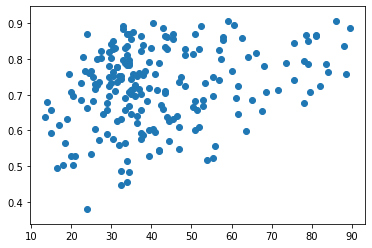

In [38]:
plt.scatter(df1['average cpi'],df1['Country Similarity'])

In [18]:
df1['Status'] = df1['Border Status'].replace('Open',1).replace('Closed',0)

In [41]:
def regression(y, df):
    import statsmodels.discrete.discrete_model as sm
    import statsmodels
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_squared_error
    df=df.dropna()
    X = df.drop([y], 1)
    y = df[y]
    X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    model = statsmodels.regression.linear_model.OLS(y_train, X_train)
    model = model.fit()
    predictions = model.predict(X_test)
    # Plot the model
    plt.figure(figsize=(8,6))
    plt.scatter(predictions, y_test, s=30, c='r', marker='+', zorder=10)
    plt.xlabel("Predicted Values - $\hat{y}$")
    plt.ylabel("Actual Values - $y$")
    plt.show()
    print("MSE:", mean_squared_error(y_test, predictions))
    return model.summary()

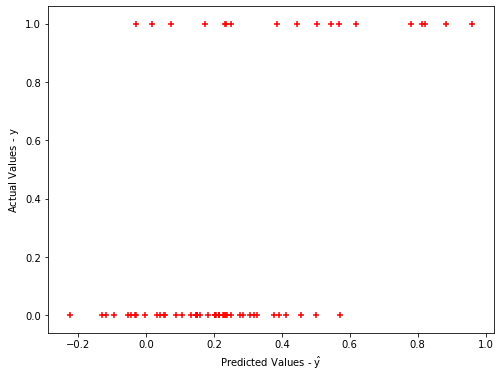

MSE: 0.14715304232544615


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 Status   R-squared (uncentered):                   0.552
Model:                            OLS   Adj. R-squared (uncentered):              0.538
Method:                 Least Squares   F-statistic:                              38.83
Date:                Fri, 14 Feb 2020   Prob (F-statistic):                    3.77e-21
Time:                        14:50:35   Log-Likelihood:                         -48.791
No. Observations:                 130   AIC:                                      105.6
Df Residuals:                     126   BIC:                                      117.1
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
average cpi                   0.0155      0.003      4.459      0.000       0.009       0.022
average db                   -0.0064      0.004     -1.729      0.086      -0.014       0.001
average pfi                  -0.0030      0.003     -1.075      0.284      -0.009       0.003
GDP per capita difference     0.2192      0.124      1.769      0.079      -0.026       0.464
==============================================================================
Omnibus:                       18.816   Durbin-Watson:                   1.789
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.131
Skew:                           0.981   Prob(JB):                     1.56e-05
Kurtosis:                       3.489   Cond. No.                         337.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
regression('Status',df1[['average cpi','average db','average pfi','GDP per capita difference','Status']])

In [28]:
df1[['average cpi','average db','average pfi','GDP per capita difference','average score','Country Similarity','viability','viability2','Status']].corr()

average cpi  average db  average pfi  \
average cpi                   1.000000    0.749939    -0.663882   
average db                    0.749939    1.000000    -0.422830   
average pfi                  -0.663882   -0.422830     1.000000   
GDP per capita difference     0.192282    0.150024    -0.307749   
average score                 0.880803    0.595661    -0.679980   
Country Similarity            0.294485    0.258426    -0.408194   
viability                     0.779286    0.516613    -0.553129   
viability2                    0.753501    0.497990    -0.554673   
Status                        0.552877    0.411677    -0.396051   

                           GDP per capita difference  average score  \
average cpi                                 0.192282       0.880803   
average db                                  0.150024       0.595661   
average pfi                                -0.307749      -0.679980   
GDP per capita difference                   1.000000       0.221657   
average score                               0.221657       1.000000   
Country Similarity                          0.345546       0.275929   
viability                                   0.159474       0.923013   
viability2                                  0.270889       0.917316   
Status                                      0.295739       0.559995   

                           Country Similarity  viability  viability2    Status  
average cpi                          0.294485   0.779286    0.753501  0.552877  
average db                           0.258426   0.516613    0.497990  0.411677  
average pfi                         -0.408194  -0.553129   -0.554673 -0.396051  
GDP per capita difference            0.345546   0.159474    0.270889  0.295739  
average score                        0.275929   0.923013    0.917316  0.559995  
Country Similarity                   1.000000   0.295184    0.306616  0.230033  
viability                            0.295184   1.000000    0.960079  0.579473  
viability2                           0.306616   0.960079    1.000000  0.564648  
Status                               0.230033   0.579473    0.564648  1.000000

In [29]:
def RFRegressor(y, df):
    X = df.drop([y], 1)
    y = df[y]
    from sklearn.ensemble import RandomForestRegressor
    rf = RandomForestRegressor()
    rf.fit(X, y)
    names = X.dtypes.index
    print("Features sorted by their score:")
    print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
                 reverse=True))
RFRegressor('Status',df1[['average cpi','average db','average pfi','GDP per capita difference','average score','Country Similarity','viability','viability2','Status']].dropna())

Features sorted by their score:
[(0.2702, 'average score'), (0.2363, 'viability'), (0.1338, 'average cpi'), (0.1058, 'GDP per capita difference'), (0.1003, 'viability2'), (0.0578, 'average pfi'), (0.0538, 'average db'), (0.042, 'Country Similarity')]


In [30]:
RFRegressor('Status',df1[['average cpi','average db','average pfi','average homicide','GDP per capita difference','Status']].dropna())

Features sorted by their score:
[(0.4411, 'average cpi'), (0.146, 'average pfi'), (0.1447, 'average homicide'), (0.1373, 'GDP per capita difference'), (0.1309, 'average db')]


In [31]:
RFRegressor('Status',df1[['average cpi','average db','average pfi','average homicide','Population difference', 'Population growth difference',
       'GDP difference', 'GDP per capita difference', 'cpi difference',
       'db difference', 'pfi difference', 'homicide difference','Status']].dropna())

Features sorted by their score:
[(0.4218, 'average cpi'), (0.1238, 'average homicide'), (0.1071, 'GDP per capita difference'), (0.0805, 'average pfi'), (0.0485, 'average db'), (0.0468, 'Population growth difference'), (0.0392, 'db difference'), (0.0357, 'homicide difference'), (0.0285, 'Population difference'), (0.0244, 'GDP difference'), (0.0222, 'cpi difference'), (0.0215, 'pfi difference')]


In [ ]:
df1.columns